In [39]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import HMC,MCMC, NUTS, Predictive
from torch.autograd import grad
import numpy as np


import matplotlib.pyplot as plt

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f'device: {device}')

device: cuda:0


In [42]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )
    def forward(self, t):
        return self.net(t)
    


pinn = PINN()

In [1]:
# sensor data
t_data = torch.linspace(0., 5., 50).unsqueeze(-1)          # [50×1]
u_true = 0.5*t_data**2 + t_data
noise = 0.1
u_data = u_true + noise * torch.randn_like(u_true)

# collocation for PDE residual
t_f = torch.linspace(0., 5., 70).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]], requires_grad=True)

NameError: name 'torch' is not defined

In [ ]:
def model(t_data, u_data, t_f, t_ic):

    # Priors over all NN parameters
    priors = {}
    for name, param in pinn.named_parameters():
        priors[name] = dist.Normal(0., 10.).expand(param.shape).to_event(param.dim())

    # create a “randomized” BNN
    bnn = pyro.random_module("bnn", pinn, priors)()

    # 3.2 Sensor‑data likelihood
    sigma_obs = pyro.sample("sigma_obs", dist.Uniform(1e-3, 5.0))
    u_pred = bnn(t_data).squeeze(-1)

    
    with pyro.plate("data", t_data.shape[0]):
        pyro.sample("obs",dist.Normal(u_pred, sigma_obs),obs=u_data.squeeze(-1))

    # 3.3 Physics residuals: du/dt – t ≈ 0
    # u_f = bnn(t_f)
    # du_dt = torch.autograd.grad(u_f, t_f,
    #                             grad_outputs=torch.ones_like(u_f),
    #                             create_graph=True, allow_unused=None)[0]
    # r_phy = (du_dt.squeeze(-1) - t_f.squeeze(-1))
    # sigma_phy = pyro.sample("sigma_phy", dist.Uniform(1e-3, 1.0))
    # with pyro.plate("physics", t_f.shape[0]):
    #     pyro.sample("phy",
    #                 dist.Normal(r_phy, sigma_phy),
    #                 obs=torch.zeros_like(r_phy))


    # Physics Residuals

    sigma_phy = pyro.sample("sigma_phy", dist.Uniform(1e-3, 5.0))

    # make sure t_f is set up for autograd
    t_f = t_f.detach().requires_grad_(True)
    with torch.enable_grad():
        u_f   = bnn(t_f)                           
        du_dt = torch.autograd.grad(u_f, t_f,grad_outputs=torch.ones_like(u_f),create_graph=True)[0]

    res_pde = (du_dt.squeeze(-1) - t_f.squeeze(-1))

    with pyro.plate("physics", t_f.shape[0]):
        pyro.sample("phy",dist.Normal(res_pde, sigma_phy).to_event(1),obs=torch.zeros_like(res_pde))



    # Initial‐condition residual
    sigma_ic = pyro.sample("sigma_ic", dist.Uniform(1e-3, 5.0))
    t_ic = t_ic.detach().requires_grad_(True)
    with torch.enable_grad():
        u0 = bnn(t_ic).squeeze(-1)
    pyro.sample("ic",dist.Normal(u0, sigma_ic),obs=torch.tensor(0.0))

    # # 3.4 Initial condition residual: u(0) = 0
    # u0 = bnn(t_ic).squeeze(-1)
    # sigma_ic = pyro.sample("sigma_ic", dist.Uniform(1e-3, 1.0))
    # pyro.sample("ic",
    #             dist.Normal(u0, sigma_ic),
    #             obs=torch.tensor(0.0))




In [46]:
pyro.clear_param_store()
nuts = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts, num_samples=200, warmup_steps=100)
mcmc.run(t_data, u_data, t_f, t_ic)

# extract posterior samples
posterior_samples = mcmc.get_samples()

Warmup:   0%|          | 0/300 [00:00, ?it/s]/home/soumik/.local/lib/python3.10/site-packages/pyro/primitives.py:526: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
Sample: 100%|██████████| 300/300 [14:56,  2.99s/it, step size=3.94e-05, acc. prob=0.566]


In [47]:
print("σ_obs:", posterior_samples['sigma_obs'].mean())
print("σ_phy:", posterior_samples['sigma_phy'].mean())
print("σ_ic :", posterior_samples['sigma_ic'].mean())

σ_obs: tensor(4.4205)
σ_phy: tensor(0.0010)
σ_ic : tensor(3.3927)


In [48]:
# 1) Check how many draws you actually have:
N = posterior_samples["bnn$$$net.0.weight"].shape[0]
print("Number of posterior draws:", N)

# 2) Make sure there really *are* multiple, different draws:
w0 = posterior_samples["bnn$$$net.0.weight"]            # shape [N, hidden, 1]
print("  unique entries in first weight matrix:",
      w0.view(N, -1)                # flatten each draw
        .unique(dim=0)              # row‑wise unique
        .shape[0], "distinct samples")

Number of posterior draws: 200
  unique entries in first weight matrix: 200 distinct samples


torch.Size([200, 50, 1])


(array([12., 44., 44.,  8., 34., 33., 15.,  4.,  3.,  3.]),
 array([-0.387712  , -0.38736296, -0.38701388, -0.38666484, -0.38631576,
        -0.38596672, -0.38561767, -0.3852686 , -0.38491955, -0.38457048,
        -0.38422143]),
 <BarContainer object of 10 artists>)

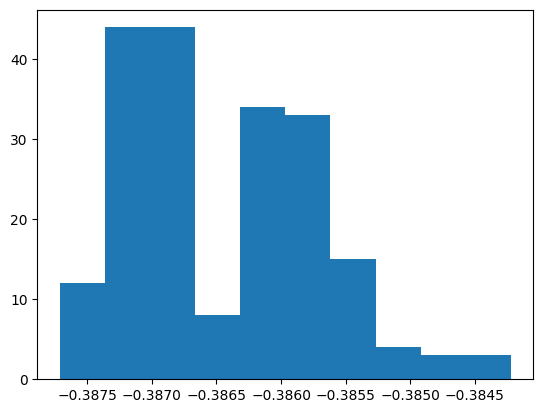

In [49]:

print(w0.shape)
plt.hist(w0[:,0,:])

In [51]:
from pyro.infer import Predictive

predictive = Predictive(model=pinn, posterior_samples=mcmc.get_samples())
t_test = torch.linspace(0., 5., 100).unsqueeze(-1)
preds = predictive(t_test)

print(preds)

{}


In [38]:
# sample 50 network parameters from the posterior
idx = torch.randperm(posterior_samples["bnn$$$net.0.weight"].shape[0])
t_test = torch.linspace(0., 5., 100).unsqueeze(-1)

all_u = []
for i in idx:
    # load one draw into a fresh network
    sampled_params = {k: posterior_samples[k][i] for k in posterior_samples if k.startswith("bnn")}
    # sampled_net = pyro.random_module("bnn_predict", pinn, sampled_params)()
    sampled_net = pyro.infer.predictive("bnn_predict", pinn, sampled_params)()

    all_u.append(sampled_net(t_test).detach().squeeze(-1))

all_u = torch.stack(all_u)  # [50×100]
print(all_u.shape)
u_mean = all_u.mean(0)
u_std  = all_u.std(0)

print(idx)

TypeError: 'module' object is not callable

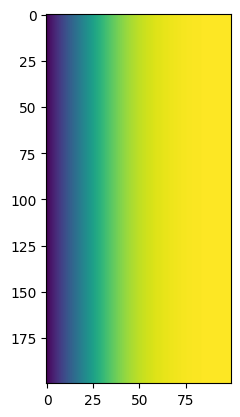

In [36]:
plt.imshow(all_u)

In [30]:
print("Posterior mean at test points:", u_mean)
print("Posterior std at test points:", u_std)

Posterior mean at test points: tensor([-0.0129, -0.0046,  0.0035,  0.0115,  0.0194,  0.0271,  0.0348,  0.0423,
         0.0497,  0.0571,  0.0644,  0.0717,  0.0789,  0.0861,  0.0932,  0.1003,
         0.1074,  0.1145,  0.1215,  0.1285,  0.1355,  0.1424,  0.1492,  0.1560,
         0.1626,  0.1692,  0.1756,  0.1819,  0.1881,  0.1941,  0.2000,  0.2057,
         0.2112,  0.2165,  0.2216,  0.2265,  0.2312,  0.2357,  0.2401,  0.2442,
         0.2481,  0.2518,  0.2554,  0.2587,  0.2619,  0.2649,  0.2677,  0.2704,
         0.2730,  0.2753,  0.2776,  0.2797,  0.2817,  0.2835,  0.2853,  0.2869,
         0.2885,  0.2899,  0.2913,  0.2926,  0.2938,  0.2949,  0.2960,  0.2970,
         0.2979,  0.2988,  0.2996,  0.3003,  0.3011,  0.3017,  0.3023,  0.3029,
         0.3035,  0.3040,  0.3045,  0.3049,  0.3053,  0.3057,  0.3060,  0.3063,
         0.3066,  0.3069,  0.3072,  0.3074,  0.3076,  0.3078,  0.3080,  0.3081,
         0.3083,  0.3084,  0.3085,  0.3086,  0.3086,  0.3087,  0.3087,  0.3088,
         

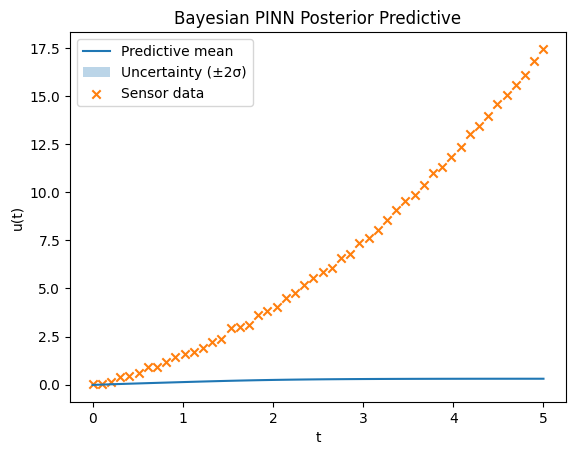

In [16]:
plt.figure()
# predictive mean
plt.plot(t_test.numpy(), u_mean.numpy(), label='Predictive mean')
# ±2σ uncertainty band
plt.fill_between(
    t_test.numpy().ravel(),
    (u_mean - 2*u_std).numpy(),
    (u_mean + 2*u_std).numpy(),
    alpha=0.3,
    label='Uncertainty (±2σ)'
)
# sensor data
plt.scatter(t_data.numpy(), u_data.numpy(), marker='x', label='Sensor data')

plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Bayesian PINN Posterior Predictive')
plt.legend()
plt.show()